In [19]:
from __future__ import division
import numpy as np
import scipy as sc
from itertools import product
import time
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
#import PIL
from numpy import log10
import random
from math import factorial
from scipy import stats
from scipy.stats import poisson, beta, mode, linregress, gaussian_kde, skewnorm, truncnorm
from scipy.spatial import distance

import warnings
import pandas as pd
import re
import os
import math
from collections import Counter
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.stats.outliers_influence import summary_table
import statsmodels.api as sm
from scipy.optimize import linear_sum_assignment
import colorsys
from collections import Counter
import scipy.optimize as opt
import scipy.special as sp
import ot
import timeit
#import scipy.stats.mstats as mstats
from math import comb

from statsmodels.distributions.empirical_distribution import ECDF


from scipy.stats import poisson, mode
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

warnings.filterwarnings('ignore')

%config InlineBackend.figure_formats = ['svg']
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

pd.set_option('display.max_columns', None)


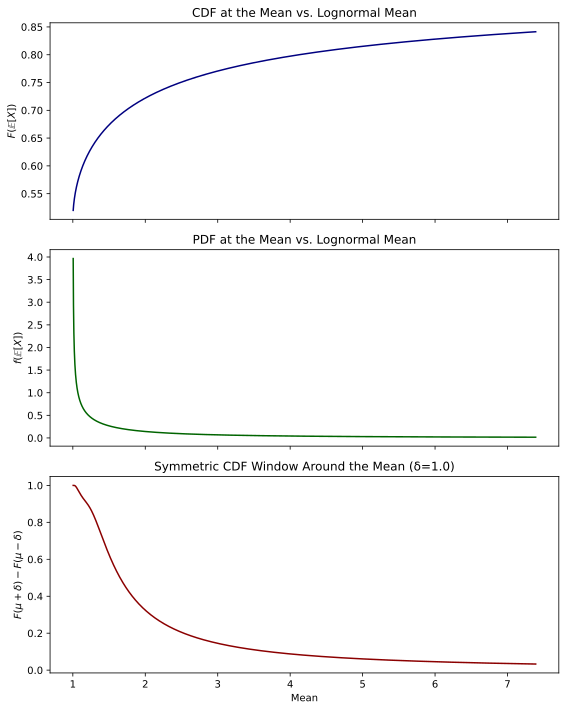

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm

# Fixed underlying normal mean
mu = 0.0

# Range of sigma (controls skew and spread)
sigma_vals = np.linspace(0.1, 2.0, 500)
means = np.exp(mu + sigma_vals**2 / 2)

# Compute CDF at the mean of the lognormal
cdf_at_mean = lognorm.cdf(means, s=sigma_vals, scale=np.exp(mu))

# Compute PDF at the mean
pdf_at_mean = lognorm.pdf(means, s=sigma_vals, scale=np.exp(mu))

# Symmetric window around the mean (δ in absolute space, not log-space)
delta = 1.0
lower = np.clip(means - delta, 1e-10, None)
upper = means + delta
cdf_window = lognorm.cdf(upper, s=sigma_vals, scale=np.exp(mu)) - \
             lognorm.cdf(lower, s=sigma_vals, scale=np.exp(mu))

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

axs[0].plot(means, cdf_at_mean, color='navy')
axs[0].set_ylabel(r'$F(\mathbb{E}[X])$')
axs[0].set_title('CDF at the Mean vs. Lognormal Mean')

axs[1].plot(means, pdf_at_mean, color='darkgreen')
axs[1].set_ylabel(r'$f(\mathbb{E}[X])$')
axs[1].set_title('PDF at the Mean vs. Lognormal Mean')

axs[2].plot(means, cdf_window, color='darkred')
axs[2].set_ylabel(r'$F(\mu+\delta) - F(\mu-\delta)$')
axs[2].set_xlabel('Mean')
axs[2].set_title('Symmetric CDF Window Around the Mean (δ=1.0)')

plt.tight_layout()
plt.show()


In [ ]:

for a,b in [(0.5,5), (2,2), (5,0.5)]:
    dist = beta(a,b)
    L, U = dist.support()    # (0,1)
    C    = dist.mean()       # a/(a+b)
    Fc   = dist.cdf(C)
    Sp   = (U - C)/(U - L)   # = 1 - C
    Sm   = (1 - Fc)/(1 - 0)  # = 1 - Fc

    print(f"a={a:4.1f}, b={b:4.1f}, mean={C:.4f}, F(mean)={Fc:.4f}, Sp={Sp:.4f}, Sm={Sm:.4f}")


In [ ]:

for a,b in [(0.5,5), (2,2), (5,0.5)]:
    dist = beta(a,b)
    C  = dist.mean()       # a/(a+b)
    Fc = dist.cdf(C)       # F(mean)
    Sp = 1 - C             # since support is [0,1]
    Sm = 1 - Fc            # since F(1)=1, F(0)=0

    print(f"a={a:4.1f}, b={b:4.1f}  →  "
          f"C={C:.4f},  F(C)={Fc:.4f},  Sp={Sp:.4f},  Sm={Sm:.4f}")


In [ ]:

def raw_distance_and_mass_shift(dist, C, L, U):
    """Return raw positional and mass differences without normalization."""
    F = dist.cdf
    pos_diff = U - C
    mass_diff = F(U) - F(C)
    return pos_diff, mass_diff

a_vals = np.linspace(0.5, 5, 100)
b_vals = np.linspace(0.5, 5, 100)

pos_diffs = []
mass_diffs = []

for a in a_vals:
    for b in b_vals:
        dist = beta(a, b)
        L, U = dist.support()
        C = dist.mean()
        pos_diff, mass_diff = raw_distance_and_mass_shift(dist, C, L, U)
        pos_diffs.append(pos_diff)
        mass_diffs.append(mass_diff)

pos_diffs = np.array(pos_diffs)
mass_diffs = np.array(mass_diffs)

plt.scatter(pos_diffs, mass_diffs, alpha=0.6)
plt.xlabel('U - C (positional distance)')
plt.ylabel('F(U) - F(C) (mass difference)')
plt.title('Raw Positional vs Mass Differences (Beta distribution)')
plt.grid(True)
plt.show()

# Calculate correlation to quantify linear association
corr = np.corrcoef(pos_diffs, mass_diffs)[0,1]
print(f'Correlation between positional distance and mass difference: {corr:.4f}')


In [ ]:

a_vals = np.linspace(0.5, 10, 100)
b_fixed = 2

C_vals  = []
F_C_vals = []
Sp_vals = []
Sm_vals = []

for a in a_vals:
    dist = beta(a, b_fixed)
    C    = dist.mean()
    F_C  = dist.cdf(C)
    Sp   = 1 - C
    Sm   = 1 - F_C

    C_vals.append(C)
    F_C_vals.append(F_C)
    Sp_vals.append(Sp)
    Sm_vals.append(Sm)

# Plot Sp and Sm as a function of center
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(C_vals, Sp_vals, label='Sp = 1 - C', color='C0')
plt.plot(C_vals, Sm_vals, label='Sm = 1 - F(C)', color='C1')
plt.xlabel('Center C (mean)')
plt.ylabel('Shift')
plt.title(f'Shift vs. Mean of Beta(a, {b_fixed})')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(Sp_vals, Sm_vals, 'o', color='C2', alpha=0.6)
plt.xlabel('Sp')
plt.ylabel('Sm')
plt.title('Sm vs. Sp')
plt.grid(True)
plt.axline((0,0), slope=1, linestyle='--', color='gray')

plt.tight_layout()
plt.show()


In [ ]:


# A narrow truncated normal on [0,1], slide mu from 0.1 to 0.9
mus = np.linspace(0.1, 0.9, 50)
sigma = 0.02
L, U = 0.0, 1.0

Sp_vals = []
Sm_vals = []
C_vals = []

for mu in mus:
    a, b = (L - mu) / sigma, (U - mu) / sigma
    dist = truncnorm(a, b, loc=mu, scale=sigma)
    C = dist.mean()  # ~ = mu, because the bump is narrow
    C_vals.append(C)
    F = dist.cdf
    Sp = (U - C) / (U - L)           # ≈ 1 - mu
    Sm = (F(U) - F(C)) / (F(U) - F(L))  # ≈ (1 - 0.5) / (1 - 0) = 0.5
    Sp_vals.append(Sp)
    Sm_vals.append(Sm)

# If you plot Sp_vals (decreasing from ~0.9 to ~0.1) 
# and Sm_vals (nearly constant ~0.5), you see they do *not* invert.


# Plot Sp and Sm as a function of center
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(C_vals, Sp_vals, label='Sp = 1 - C', color='C0')
plt.plot(C_vals, Sm_vals, label='Sm = 1 - F(C)', color='C1')
plt.xlabel('Center C (mean)')
plt.ylabel('Shift')
plt.title(f'Shift vs. Mean of Beta(a, {b_fixed})')
plt.legend()
plt.grid(True)

In [ ]:


a_vals = np.linspace(0.5, 5, 30)
b_fixed = 2.0

Sp_vals = []
Sm_vals = []

for a in a_vals:
    dist = beta(a, b_fixed)
    C = dist.mean()       # or use get_center(dist, 'mean') if needed
    F = dist.cdf
    Sp = C                # since L = 0, U = 1 → (C - 0)/(1 - 0) = C
    Sm = F(C)             # since F(0)=0, F(1)=1
    Sp_vals.append(Sp)
    Sm_vals.append(Sm)

plt.plot(Sp_vals, Sm_vals, marker='o', label='Beta(a, b=2)')
plt.plot([0, 1], [0, 1], 'r--', label='Sp = Sm')
plt.xlabel('Sp (center position)')
plt.ylabel('Sm (mass shift)')
plt.title('Sp vs. Sm for increasing a in Beta(a, 2)')
plt.legend()
plt.grid(True)
plt.show()


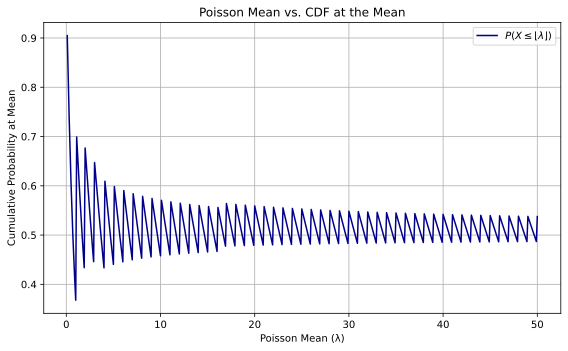

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

# Define a range of lambda (mean) values
lambdas = np.linspace(0.1, 50, 500)
means = lambdas  # For Poisson, mean = λ

# Compute the CDF at floor(lambda) for each lambda
cdf_at_mean = poisson.cdf(np.floor(lambdas), mu=lambdas)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(means, cdf_at_mean, label=r'$P(X \leq \lfloor \lambda \rfloor)$', color='darkblue')
plt.xlabel('Poisson Mean (λ)')
plt.ylabel('Cumulative Probability at Mean')
plt.title('Poisson Mean vs. CDF at the Mean')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


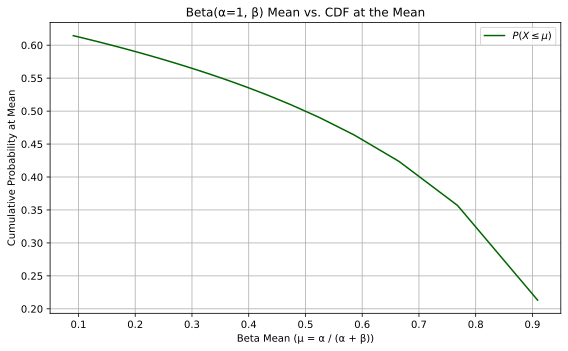

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# Alpha fixed at 1.0
alpha = 1.0

# Define a range of beta values
betas = np.linspace(0.1, 10, 50)
means = alpha / (alpha + betas)

# Compute CDF at the mean
cdf_at_mean = beta.cdf(means, a=alpha, b=betas)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(means, cdf_at_mean, label=r'$P(X \leq \mu)$', color='darkgreen')
plt.xlabel('Beta Mean (μ = α / (α + β))')
plt.ylabel('Cumulative Probability at Mean')
plt.title('Beta(α=1, β) Mean vs. CDF at the Mean')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


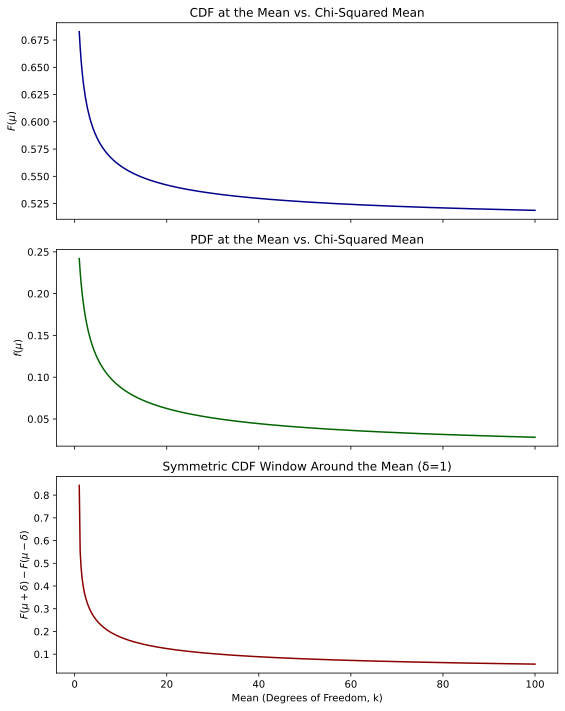

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

# Range of degrees of freedom (mean = k)
k_vals = np.linspace(1, 100, 500)
means = k_vals
delta = 1.0  # Symmetric window around the mean

# CDF at the mean
cdf_at_mean = chi2.cdf(means, df=k_vals)

# PDF at the mean
pdf_at_mean = chi2.pdf(means, df=k_vals)

# Symmetric CDF window around the mean
cdf_window = chi2.cdf(means + delta, df=k_vals) - chi2.cdf(means - delta, df=k_vals)

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

axs[0].plot(means, cdf_at_mean, color='darkblue')
axs[0].set_ylabel(r'$F(\mu)$')
axs[0].set_title('CDF at the Mean vs. Chi-Squared Mean')

axs[1].plot(means, pdf_at_mean, color='darkgreen')
axs[1].set_ylabel(r'$f(\mu)$')
axs[1].set_title('PDF at the Mean vs. Chi-Squared Mean')

axs[2].plot(means, cdf_window, color='darkred')
axs[2].set_ylabel(r'$F(\mu+\delta) - F(\mu-\delta)$')
axs[2].set_xlabel('Mean (Degrees of Freedom, k)')
axs[2].set_title('Symmetric CDF Window Around the Mean (δ=1)')

plt.tight_layout()
plt.show()


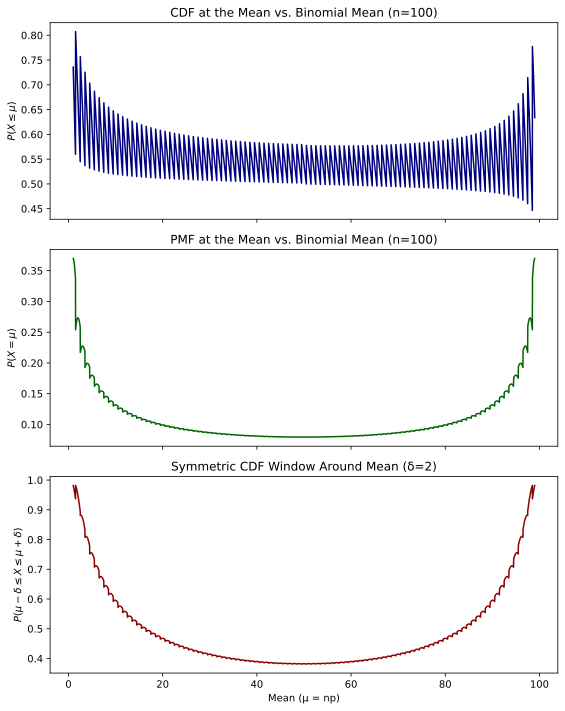

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom

# Fixed number of trials
n = 100
delta = 2  # window size for symmetric CDF window

# Range of probabilities
p_vals = np.linspace(0.01, 0.99, 5000)
means = n * p_vals
means_int = np.round(means).astype(int)  # for PMF and CDF

# Compute CDF at the mean (rounded)
cdf_at_mean = binom.cdf(means_int, n=n, p=p_vals)

# Compute PMF at the mean
pmf_at_mean = binom.pmf(means_int, n=n, p=p_vals)

# Symmetric window around the mean
low = np.clip(means_int - delta, 0, n)
high = np.clip(means_int + delta, 0, n)
cdf_window = binom.cdf(high, n=n, p=p_vals) - binom.cdf(low - 1, n=n, p=p_vals)

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

axs[0].plot(means, cdf_at_mean, color='navy')
axs[0].set_ylabel(r'$P(X \leq \mu)$')
axs[0].set_title('CDF at the Mean vs. Binomial Mean (n=100)')

axs[1].plot(means, pmf_at_mean, color='darkgreen')
axs[1].set_ylabel(r'$P(X = \mu)$')
axs[1].set_title('PMF at the Mean vs. Binomial Mean (n=100)')

axs[2].plot(means, cdf_window, color='darkred')
axs[2].set_ylabel(r'$P(\mu - \delta \leq X \leq \mu + \delta)$')
axs[2].set_xlabel('Mean (μ = np)')
axs[2].set_title('Symmetric CDF Window Around Mean (δ=2)')

plt.tight_layout()
plt.show()


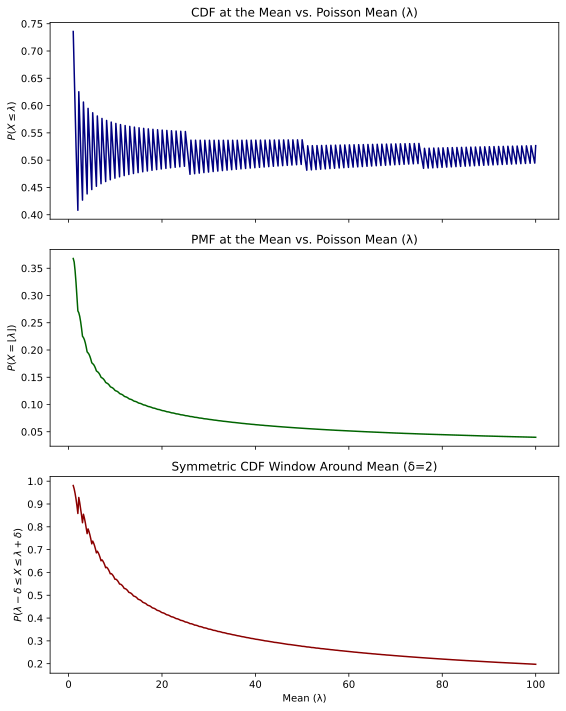

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

# λ range
lambda_vals = np.linspace(1, 100, 500)
delta = 2

# Integer versions for PMF and CDF
lambda_int = np.floor(lambda_vals).astype(int)
low = np.clip(lambda_int - delta, 0, None)
high = lambda_int + delta

# Compute CDF at mean (fractional mean handled by scipy as floor internally)
cdf_at_mean = poisson.cdf(lambda_vals, mu=lambda_vals)

# Compute PMF at floor of mean
pmf_at_mean = poisson.pmf(lambda_int, mu=lambda_vals)

# Symmetric CDF window: P(λ−δ ≤ X ≤ λ+δ)
cdf_window = poisson.cdf(high, mu=lambda_vals) - poisson.cdf(low - 1, mu=lambda_vals)

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

axs[0].plot(lambda_vals, cdf_at_mean, color='navy')
axs[0].set_ylabel(r'$P(X \leq \lambda)$')
axs[0].set_title('CDF at the Mean vs. Poisson Mean (λ)')

axs[1].plot(lambda_vals, pmf_at_mean, color='darkgreen')
axs[1].set_ylabel(r'$P(X = \lfloor \lambda \rfloor)$')
axs[1].set_title('PMF at the Mean vs. Poisson Mean (λ)')

axs[2].plot(lambda_vals, cdf_window, color='darkred')
axs[2].set_ylabel(r'$P(\lambda - \delta \leq X \leq \lambda + \delta)$')
axs[2].set_xlabel('Mean (λ)')
axs[2].set_title('Symmetric CDF Window Around Mean (δ=2)')

plt.tight_layout()
plt.show()


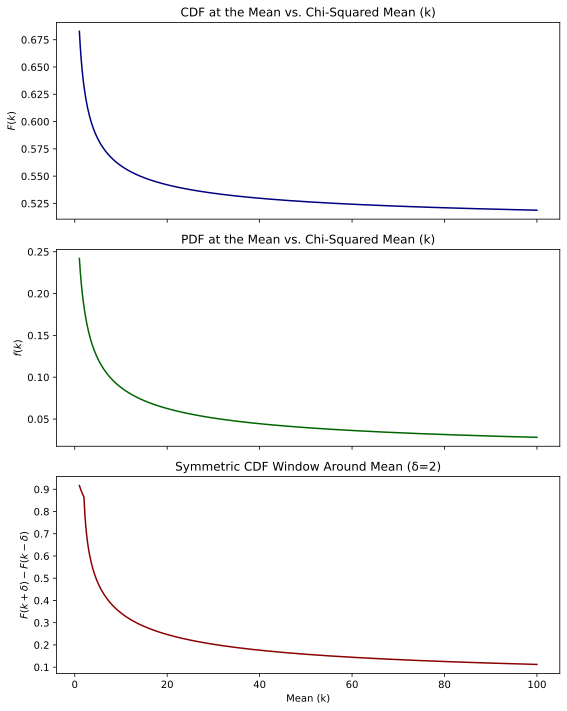

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

# Range of degrees of freedom (and means)
k_vals = np.linspace(1, 100, 500)
delta = 2.0  # symmetric window around the mean

# CDF at the mean
cdf_at_mean = chi2.cdf(k_vals, df=k_vals)

# PDF at the mean
pdf_at_mean = chi2.pdf(k_vals, df=k_vals)

# Symmetric CDF window around the mean
lower = np.clip(k_vals - delta, 0, None)
upper = k_vals + delta
cdf_window = chi2.cdf(upper, df=k_vals) - chi2.cdf(lower, df=k_vals)

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

axs[0].plot(k_vals, cdf_at_mean, color='navy')
axs[0].set_ylabel(r'$F(k)$')
axs[0].set_title('CDF at the Mean vs. Chi-Squared Mean (k)')

axs[1].plot(k_vals, pdf_at_mean, color='darkgreen')
axs[1].set_ylabel(r'$f(k)$')
axs[1].set_title('PDF at the Mean vs. Chi-Squared Mean (k)')

axs[2].plot(k_vals, cdf_window, color='darkred')
axs[2].set_ylabel(r'$F(k+\delta) - F(k-\delta)$')
axs[2].set_xlabel('Mean (k)')
axs[2].set_title('Symmetric CDF Window Around Mean (δ=2)')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def compute_shifts(dist, center, L, U):
    """
    Compute Sp and Sm for a (possibly truncated) distribution.
    - dist: a frozen scipy.stats object
    - center: C (mean, median, or mode)
    - L, U: numeric bounds (float)
    """
    F = dist.cdf
    # Positional shift:
    Sp = (U - center) / (U - L)

    # Mass shift:
    # If F(L)==0 and F(U)==1, this reduces to (1 - F(C)), etc.
    numerator   = F(U) - F(center)
    denominator = F(U) - F(L)
    Sm = numerator / denominator
    return Sp, Sm


def get_center(dist, method='mean'):
    """
    Return the chosen center:
    - 'mean': dist.mean()
    - 'median': dist.median()
    - 'mode': for discrete, use dist.mode();
              for continuous, approximate via max PDF over a grid.
    """
    if method == 'mean':
        return dist.mean()
    elif method == 'median':
        return dist.median()
    elif method == 'mode':
        # Discrete distributions often have dist.mode();
        # Continuous ones need a quick grid search.
        if hasattr(dist, 'mode'):
            # dist.mode() returns an array for frozen discrete distributions
            m = dist.mode()
            return float(m[0]) if hasattr(m, "__len__") else float(m)
        else:
            # continuous: grid search between 0.01 and 0.99 quantiles
            x_grid = np.linspace(dist.ppf(0.01), dist.ppf(0.99), 1000)
            pdf_vals = dist.pdf(x_grid)
            return x_grid[np.argmax(pdf_vals)]
    else:
        raise ValueError("method must be one of ['mean','median','mode'].")

def explore_shifts(dist_name, center_method='mean', param_grid=None):
    """
    Plot Sp vs. Sm for various parameter values of:
      'beta', 'binom', 'poisson', 'chi2', or 'skewnorm'.

    For bounded-support distributions, use their natural support
    (dist.support()) as (L, U). For unbounded, use [ppf(0.01), ppf(0.99)].
    """
    results = []

    if dist_name == 'beta':
        a_vals = param_grid.get('a', [2])
        b_vals = param_grid.get('b', [5])
        for a in a_vals:
            for b in b_vals:
                dist = stats.beta(a, b)
                L, U = dist.support()    # = (0, 1)
                C    = get_center(dist, center_method)
                Sp, Sm = compute_shifts(dist, C, L, U)
                results.append((a, b, Sp, Sm))
        results = np.array(results)
        plt.scatter(results[:,2], results[:,3], c='C0')
        plt.xlabel('Sp (positional shift)')
        plt.ylabel('Sm (mass shift)')
        plt.title(f'Beta(a,b)  –  center="{center_method}"')
        plt.plot([0,1],[0,1],'r--',label='Sp=Sm')
        plt.legend()
        plt.show()

    elif dist_name == 'binom':
        n_vals = param_grid.get('n', [20])
        p_vals = param_grid.get('p', np.linspace(0.1, 0.9, 9))
        for n in n_vals:
            for p in p_vals:
                dist = stats.binom(n, p)
                L, U = dist.support()  # = (0, n)
                C    = get_center(dist, center_method)
                Sp, Sm = compute_shifts(dist, C, L, U)
                results.append((n, p, Sp, Sm))
        results = np.array(results)
        plt.scatter(results[:,2], results[:,3], c='C1')
        plt.xlabel('Sp')
        plt.ylabel('Sm')
        plt.title(f'Binomial(n,p)  –  center="{center_method}"')
        plt.plot([0,1],[0,1],'r--',label='Sp=Sm')
        plt.legend()
        plt.show()

    elif dist_name == 'poisson':
        lambda_vals = param_grid.get('lambda', np.linspace(0.1, 20, 30))
        for lam in lambda_vals:
            dist = stats.poisson(mu=lam)
            # Poisson is unbounded on the right, so pick 1%/99% quantiles:
            L, U = 0, dist.ppf(0.9999999)
            C    = get_center(dist, center_method)
            Sp, Sm = compute_shifts(dist, C, L, U)
            results.append((lam, Sp, Sm))
        results = np.array(results)
        plt.scatter(results[:,1], results[:,2], c='C2')
        plt.xlabel('Sp')
        plt.ylabel('Sm')
        plt.title(f'Poisson(λ)  –  center="{center_method}"')
        plt.plot([0,1],[0,1],'r--',label='Sp=Sm')
        plt.legend()
        plt.show()

    elif dist_name == 'chi2':
        df_vals = param_grid.get('df', np.linspace(1, 20, 20))
        for df in df_vals:
            dist = stats.chi2(df)
            # Unbounded right tail:
            L, U = dist.ppf(0.01), dist.ppf(0.99)
            C    = get_center(dist, center_method)
            Sp, Sm = compute_shifts(dist, C, L, U)
            results.append((df, Sp, Sm))
        results = np.array(results)
        plt.scatter(results[:,1], results[:,2], c='C3')
        plt.xlabel('Sp')
        plt.ylabel('Sm')
        plt.title(f'Chi²(df)  –  center="{center_method}"')
        plt.plot([0,1],[0,1],'r--',label='Sp=Sm')
        plt.legend()
        plt.show()

    elif dist_name == 'skewnorm':
        a_vals = param_grid.get('a', np.linspace(-10, 10, 30))
        for a in a_vals:
            dist = stats.skewnorm(a)
            L, U = dist.ppf(0.01), dist.ppf(0.99)
            C    = get_center(dist, center_method)
            Sp, Sm = compute_shifts(dist, C, L, U)
            results.append((a, Sp, Sm))
        results = np.array(results)
        plt.scatter(results[:,1], results[:,2], c='C4')
        plt.xlabel('Sp')
        plt.ylabel('Sm')
        plt.title(f'SkewNorm(a)  –  center="{center_method}"')
        plt.plot([0,1],[0,1],'r--',label='Sp=Sm')
        plt.legend()
        plt.show()

    else:
        raise ValueError(f"Unsupported distribution: {dist_name}")

# Example:
if __name__ == "__main__":
    # Beta(a,b) with mean as center
    explore_shifts(
        'beta',
        center_method='mean',
        param_grid={'a': np.linspace(0.5, 5, 10),
                    'b': np.linspace(0.5, 5, 10)}
    )

    
    # If you really want to see that Sm=0.5 when center='median':
    explore_shifts(
        'beta',
        center_method='median',
        param_grid={'a': np.linspace(0.5, 5, 10),
                    'b': np.linspace(0.5, 5, 10)}
    )
    # You’ll observe a horizontal line at Sm=0.5, since F(median)=0.5 for any Beta.

    # Poisson(λ) with mean as center
    explore_shifts(
        'poisson',
        center_method='mean',
        param_grid={'lambda': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
    )


In [ ]:
centers = []
Sp_vals = []
Sm_vals = []

a_vals = np.linspace(0.5, 5, 50)
for a in a_vals:
    b = 5  # fix b
    dist = stats.beta(a, b)
    C = dist.mean()  # or try median
    L, U = dist.support()
    Sp, Sm = compute_shifts(dist, C, L, U)
    centers.append(C)
    Sp_vals.append(Sp)
    Sm_vals.append(Sm)

plt.plot(centers, Sp_vals, label='S_p', color='blue')
plt.plot(centers, Sm_vals, label='S_m', color='orange')
plt.xlabel('Center (mean)')
plt.ylabel('Shift value')
plt.title('S_p and S_m vs center (Beta)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:

def compute_Sm(distribution, lam, mass_cutoff):
    dist = distribution(lam)
    L = 0
    U = int(np.round(dist.ppf(mass_cutoff)))
    C = lam  # center

    if L >= U:
        return 0, 0, L, U, 0

    xs = np.arange(L, U + 1)
    pmf_vals = dist.pmf(xs)
    total_mass = np.sum(pmf_vals)
    norm_pmf = pmf_vals / total_mass

    mean_trunc = np.sum(xs * norm_pmf)
    var_trunc = np.sum((xs - mean_trunc) ** 2 * norm_pmf)
    std = np.sqrt(var_trunc)

    skew = 0
    if std > 0:
        skew = np.sum((xs - mean_trunc) ** 3 * norm_pmf) / (std ** 3)

    samples = np.repeat(xs, (norm_pmf * 1e5).astype(int))
    ecdf = ECDF(samples)

    F_L = ecdf(L)
    F_C = ecdf(C)
    F_U = ecdf(U)

    mass_total = F_U - F_L
    mass_upper = F_U - F_C
    shift = mass_upper / mass_total if mass_total > 0 else 0

    return shift, skew, L, U, mean_trunc

# Parameters
lambdas = [0.01, 0.1, 1, 10, 100, 1000, 10000]
mass_cutoff = 0.9999999999

# Evaluation
print(f"{'Lambda':>10} | {'Full Skew':>10} | {'Trunc Skew':>12} | {'Rel Error':>10}")
print("-" * 50)

for lam in lambdas:
    dist = poisson(lam)
    full_skew = dist.stats(moments='s')
    shift, trunc_skew, L, U, mean_trunc = compute_Sm(poisson, lam, mass_cutoff)

    rel_error = abs(trunc_skew - full_skew) / abs(full_skew) if full_skew != 0 else float('nan')
    print(f"{lam:10.3g} | {full_skew:10.5f} | {trunc_skew:12.5f} | {rel_error:10.5f}")


In [ ]:

def compute_shift_components_analytic(distribution, param, mass_cutoff):
    dist = distribution(param)

    # Find truncation bounds L and U from quantiles (equal tail)
    lower_q = (1 - mass_cutoff) / 2
    upper_q = 1 - lower_q
    L = dist.ppf(lower_q)
    U = dist.ppf(upper_q)

    if L >= U:
        # pathological case
        return 0, 0, 0, 0, L, U, 0

    # For discrete distribution:
    if hasattr(dist, 'pmf'):
        xs = np.arange(np.floor(L), np.ceil(U) + 1)
        pmf_vals = dist.pmf(xs)
        total_mass = pmf_vals.sum()
        norm_pmf = pmf_vals / total_mass
        mean_trunc = np.sum(xs * norm_pmf)
        var_trunc = np.sum((xs - mean_trunc) ** 2 * norm_pmf)
        std_trunc = np.sqrt(var_trunc)
        skew = np.sum(((xs - mean_trunc) ** 3) * norm_pmf) / std_trunc**3 if std_trunc > 0 else 0

        # Compute shifts using a mass-based ECDF-like approximation
        multiplier = min(int(1e5), max(int(1e3), int(1 / np.min(norm_pmf[norm_pmf > 0]))))
        counts = (norm_pmf * multiplier).astype(int)
        data = np.repeat(xs, counts)
        Sm, Sp, Sh = compute_shift_components(data, L=L, U=U, center='mean')

    else:
        # For continuous distribution:
        # Discretize support finely for approximation
        xs = np.linspace(L, U, 10000)
        pdf_vals = dist.pdf(xs)
        dx = xs[1] - xs[0]
        total_mass = np.sum(pdf_vals * dx)
        norm_pdf = pdf_vals / total_mass
        mean_trunc = np.sum(xs * norm_pdf * dx)
        var_trunc = np.sum((xs - mean_trunc) ** 2 * norm_pdf * dx)
        std_trunc = np.sqrt(var_trunc)
        skew = np.sum(((xs - mean_trunc) ** 3) * norm_pdf * dx) / std_trunc**3 if std_trunc > 0 else 0

        # Compute ECDF from pdf
        cdf_vals = np.cumsum(norm_pdf) * dx
        def ecdf(x):
            # interpolate cdf for arbitrary x in [L, U]
            return np.interp(x, xs, cdf_vals)

        # Mass-based shift
        F_L = ecdf(L)
        F_U = ecdf(U)
        C = mean_trunc
        F_C = ecdf(C)
        mass_total = F_U - F_L
        mass_upper = F_U - F_C
        Sm = mass_upper / mass_total if mass_total > 0 else 0

        # Positional shift
        Sp = (U - C) / (U - L) if (U - L) > 0 else 0
        Sh = (Sm + Sp) / 2

    return Sm, Sp, Sh, skew, L, U, mean_trunc



# Parameters
dfs = [1, 10, 100, 1000, 10000, 100000]
mass_cutoffs = np.array([
    0.9, 0.99, 0.999, 0.9999, 0.99999, 0.999999,
    0.9999999, 0.99999999, 0.999999999, 0.9999999999,
    0.99999999999, 0.999999999999, 0.9999999999999,
    0.99999999999999, 0.999999999999999
])
xvals = -np.log10(1 - mass_cutoffs)

results = {df: {'mean': [], 'skew': [], 'shift': []} for df in dfs}

for df in dfs:
    for cutoff in mass_cutoffs:
        
        Sm, Sp, Sh, skew, L, U, mean_trunc = compute_shift_components_analytic(poisson, df, cutoff)
        
        results[df]['mean'].append(mean_trunc)
        results[df]['skew'].append(skew)
        results[df]['shift'].append(Sm)  # Use hybrid shift Sh here

        
# Plotting
fig, axs = plt.subplots(1, 3, figsize=(13, 3.5))
fs = 13
colors = ['r', 'orange', 'yellow', 'green', 'blue', 'violet']

for i, df in enumerate(dfs):
    label = rf'df = {df}'
    axs[0].plot(xvals, results[df]['mean'], label=label, color=colors[i])
    axs[1].plot(xvals, results[df]['skew'], label=label, color=colors[i])
    axs[2].plot(xvals, results[df]['shift'], label=label, color=colors[i])

axs[0].set_ylabel('Truncated mean', fontsize=fs)
axs[1].set_ylabel('Truncated skewness', fontsize=fs)
axs[2].set_ylabel(r'Truncated $\mathcal{S}$ (hybrid shift)', fontsize=fs + 1)

for ax in axs:
    ax.set_xlabel(r'$-\log_{10}(1 - \mathrm{mass\ cutoff})$', fontsize=fs)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(fontsize=fs - 2)

fig.patch.set_facecolor('white')
plt.tight_layout()
plt.show()


In [ ]:

# Parameters
a_vals = [-10, -2, 0, 2, 10, 50]  # skewness parameters (negative, zero, positive)
mass_cutoffs = np.array([
    0.9, 0.99, 0.999, 0.9999, 0.99999, 0.999999,
    0.9999999, 0.99999999, 0.999999999,
    0.9999999999, 0.99999999999,
])

xvals = -np.log10(1 - mass_cutoffs)

results = {a: {'mean': [], 'skew': [], 'shift': []} for a in a_vals}

for a in a_vals:
    for cutoff in mass_cutoffs:
        
        Sm, Sp, Sh, skew, L, U, mean_trunc = compute_shift_components_analytic(skewnorm, a, cutoff)
        
        results[a]['mean'].append(mean_trunc)
        results[a]['skew'].append(skew)
        results[a]['shift'].append(Sm)
        
# Plotting
fig, axs = plt.subplots(1, 3, figsize=(13, 3.5))
fs = 13
colors = ['red', 'orange', 'gray', 'green', 'blue', 'violet']

for i, a in enumerate(a_vals):
    label = rf'$a = {a}$'
    axs[0].plot(xvals, results[a]['mean'], label=label, color=colors[i])
    axs[1].plot(xvals, results[a]['skew'], label=label, color=colors[i])
    axs[2].plot(xvals, results[a]['shift'], label=label, color=colors[i])

axs[0].set_ylabel('Truncated mean', fontsize=fs)
axs[1].set_ylabel('Truncated skewness', fontsize=fs)
axs[2].set_ylabel(r'Truncated $\mathcal{S}$', fontsize=fs + 1)

for ax in axs:
    ax.set_xlabel(r'$-\log_{10}(1 - \mathrm{mass\ cutoff})$', fontsize=fs)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(fontsize=fs - 2)

fig.patch.set_facecolor('white')
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

def s_window_shift_and_skew(distribution, df, mass_cutoff):
    dist = distribution(df=df)

    lower_q = (1 - mass_cutoff) / 2
    upper_q = 1 - lower_q
    L = dist.ppf(lower_q)
    U = dist.ppf(upper_q)

    if not np.isfinite(L) or not np.isfinite(U) or L >= U:
        return 0, 0, 0, 0, 0

    xs = np.linspace(L, U, 2000)
    pdf_vals = dist.pdf(xs)
    norm_pdf = pdf_vals / np.trapz(pdf_vals, xs)  # Renormalize

    mean_trunc = np.trapz(xs * norm_pdf, xs)
    var_trunc = np.trapz((xs - mean_trunc) ** 2 * norm_pdf, xs)
    std = np.sqrt(var_trunc)
    skew = np.trapz((xs - mean_trunc) ** 3 * norm_pdf, xs) / std**3 if std > 0 else 0
    shift = (U - mean_trunc) / (U - L) if U > L else 0

    return shift, skew, L, U, mean_trunc

# Parameters
dfs = [1, 10, 100, 1000, 10000, 100000]
mass_cutoffs = np.array([
    0.9, 0.99, 0.999, 0.9999, 0.99999, 0.999999,
    #0.9999999, 0.99999999, 0.999999999, 0.9999999999,
    #0.99999999999, 0.999999999999, 0.9999999999999,
    #0.99999999999999, 0.999999999999999
])
xvals = -np.log10(1 - mass_cutoffs)

results = {df: {'mean': [], 'skew': [], 'shift': []} for df in dfs}

for df in dfs:
    for cutoff in mass_cutoffs:
        shift, skew, L, U, mean = s_window_shift_and_skew(chi2, df, cutoff)
        results[df]['mean'].append(mean)
        results[df]['skew'].append(skew)
        results[df]['shift'].append(shift)

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(13, 3.5))
fs = 13
colors = ['r', 'orange', 'yellow', 'green', 'blue', 'violet']

for i, df in enumerate(dfs):
    label = rf'df = {df}'
    axs[0].plot(xvals, results[df]['mean'], label=label, color=colors[i])
    axs[1].plot(xvals, results[df]['skew'], label=label, color=colors[i])
    axs[2].plot(xvals, results[df]['shift'], label=label, color=colors[i])

axs[0].set_ylabel('Truncated mean', fontsize=fs)
axs[1].set_ylabel('Truncated skewness', fontsize=fs)
axs[2].set_ylabel(r'Truncated $\mathcal{S}$', fontsize=fs + 1)

for ax in axs:
    ax.set_xlabel(r'$-\log_{10}(1 - \mathrm{mass\ cutoff})$', fontsize=fs)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(fontsize=fs - 2)

fig.patch.set_facecolor('white')
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

def s_window_shift_and_skew(distribution, df, mass_cutoff):
    dist = distribution(df=df)

    lower_q = (1 - mass_cutoff) / 2
    upper_q = 1 - lower_q
    L = dist.ppf(lower_q)
    U = dist.ppf(upper_q)

    if not np.isfinite(L) or not np.isfinite(U) or L >= U:
        return 0, 0, 0, 0, 0

    xs = np.linspace(L, U, 2000)
    pdf_vals = dist.pdf(xs)
    norm_pdf = pdf_vals / np.trapz(pdf_vals, xs)  # Renormalize

    mean_trunc = np.trapz(xs * norm_pdf, xs)
    var_trunc = np.trapz((xs - mean_trunc) ** 2 * norm_pdf, xs)
    std = np.sqrt(var_trunc)
    skew = np.trapz((xs - mean_trunc) ** 3 * norm_pdf, xs) / std**3 if std > 0 else 0
    shift = (U - mean_trunc) / (U - L) if U > L else 0

    return shift, skew, L, U, mean_trunc

# Parameters
dfs = [1, 10, 100, 1000, 10000, 100000]
mass_cutoffs = np.array([
    0.9, 0.99, 0.999, 0.9999, 0.99999, 0.999999,
    #0.9999999, 0.99999999, 0.999999999, 0.9999999999,
    #0.99999999999, 0.999999999999, 0.9999999999999,
    #0.99999999999999, 0.999999999999999
])
xvals = -np.log10(1 - mass_cutoffs)

results = {df: {'mean': [], 'skew': [], 'shift': []} for df in dfs}

for df in dfs:
    for cutoff in mass_cutoffs:
        shift, skew, L, U, mean = s_window_shift_and_skew(chi2, df, cutoff)
        results[df]['mean'].append(mean)
        results[df]['skew'].append(skew)
        results[df]['shift'].append(shift)

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(13, 3.5))
fs = 13
colors = ['r', 'orange', 'yellow', 'green', 'blue', 'violet']

for i, df in enumerate(dfs):
    label = rf'df = {df}'
    axs[0].plot(xvals, results[df]['mean'], label=label, color=colors[i])
    axs[1].plot(xvals, results[df]['skew'], label=label, color=colors[i])
    axs[2].plot(xvals, results[df]['shift'], label=label, color=colors[i])

axs[0].set_ylabel('Truncated mean', fontsize=fs)
axs[1].set_ylabel('Truncated skewness', fontsize=fs)
axs[2].set_ylabel(r'Truncated $\mathcal{S}$', fontsize=fs + 1)

for ax in axs:
    ax.set_xlabel(r'$-\log_{10}(1 - \mathrm{mass\ cutoff})$', fontsize=fs)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(fontsize=fs - 2)

fig.patch.set_facecolor('white')
plt.tight_layout()
plt.show()

In [ ]:
# Parameters
dfs = [1, 10, 100, 1000, 10000, 100000]
mass_cutoffs = np.array([
    0.9, 0.99, 0.999, 0.9999, 0.99999, 0.999999,
    0.9999999, 0.99999999, 0.999999999, 0.9999999999,
])
xvals = -np.log10(1 - mass_cutoffs)

results = {df: {'mean': [], 'skew': [], 'shift': []} for df in dfs}

for df in dfs:
    for cutoff in mass_cutoffs:
        shift, skew, L, U, mean = s_window_shift_and_skew(chi2, df, cutoff)
        results[df]['mean'].append(mean)
        results[df]['skew'].append(skew)
        results[df]['shift'].append(shift)

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(13, 3.5))
fs = 13
colors = ['r', 'orange', 'yellow', 'green', 'blue', 'violet']

for i, df in enumerate(dfs):
    label = rf'df = {df}'
    axs[0].plot(xvals, results[df]['mean'], label=label, color=colors[i])
    axs[1].plot(xvals, results[df]['skew'], label=label, color=colors[i])
    axs[2].plot(xvals, results[df]['shift'], label=label, color=colors[i])

axs[0].set_ylabel('Truncated mean', fontsize=fs)
axs[1].set_ylabel('Truncated skewness', fontsize=fs)
axs[2].set_ylabel(r'Truncated $\mathcal{S}$', fontsize=fs + 1)

for ax in axs:
    ax.set_xlabel(r'$-\log_{10}(1 - \mathrm{mass\ cutoff})$', fontsize=fs)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(fontsize=fs - 2)

fig.patch.set_facecolor('white')
plt.tight_layout()
plt.show()

In [ ]:

def find_optimal_mass_cutoff(distribution, lam=10**7, lower=0.99, upper=0.9999999999, 
                             tol=1e-8, max_mean_dev=0.01, max_var_dev=0.05):
    """
    Finds the highest mass_cutoff such that shift >= 0.5 and
    truncated mean/variance approximate the original distribution.
    """
    def is_valid(cutoff):
        result = s_window_shift_and_skew(distribution, lam, mass_cutoff=cutoff, return_variance=True)
        shift, _, _, _, mean_trunc, var_trunc = result
        mean_dev = abs(mean_trunc - lam) / lam
        var_dev = abs(var_trunc - lam) / lam
        return shift >= 0.5 and mean_dev < max_mean_dev and var_dev < max_var_dev

    while upper - lower > tol:
        mid = (lower + upper) / 2
        if is_valid(mid):
            lower = mid
        else:
            upper = mid
    return lower

def s_window_shift_and_skew(distribution, param, mass_cutoff=None, return_variance=False):
    """
    Computes Shift (𝒮), skewness, L, U, truncated mean and optionally variance.
    """
    param = float(param)
    dist = distribution(mu=param) if distribution == poisson else distribution(*param)

    # Quantile-based bounds
    lower_q = (1 - mass_cutoff) / 2
    upper_q = 1 - lower_q

    try:
        L = int(np.floor(dist.ppf(lower_q)))
        U = int(np.ceil(dist.ppf(upper_q)))
    except Exception:
        return (0, 0, 0, 0, 0, 0) if return_variance else (0, 0, 0, 0, 0)

    if L >= U:
        return (0, 0, L, U, 0, 0) if return_variance else (0, 0, L, U, 0)

    support = np.arange(L, U + 1)
    pmf = dist.pmf(support)
    total_mass = np.sum(pmf)

    if total_mass == 0:
        return (0, 0, L, U, 0, 0) if return_variance else (0, 0, L, U, 0)

    norm_pmf = pmf / total_mass
    mean_trunc = np.sum(support * norm_pmf)
    var_trunc = np.sum((support - mean_trunc) ** 2 * norm_pmf)
    std = np.sqrt(var_trunc)
    skew = np.sum((support - mean_trunc) ** 3 * norm_pmf) / std**3 if std > 0 else 0
    shift = (U - mean_trunc) / (U - L) if U > L else 0

    if return_variance:
        return shift, skew, L, U, mean_trunc, var_trunc
    else:
        return shift, skew, L, U, mean_trunc

    
# Find optimal mass cutoff that meets shift and moment constraints
#mass_cutoff = find_optimal_mass_cutoff(poisson)
#print('Optimal mass cutoff:', mass_cutoff)

mass_cutoff = 0.9999999999
# Generate λ values
lambdas = np.logspace(-3, 6, 500).tolist()

shift_vals = []
skew_vals = []
Ls = []
Us = []
means = []

for lam in lambdas:
    shift, skew, L, U, mean = s_window_shift_and_skew(poisson, lam, mass_cutoff)
    shift_vals.append(shift)
    skew_vals.append(skew)
    Ls.append(L)
    Us.append(U)
    means.append(mean)

fs = 14

# True/reference values
true_means = np.array(lambdas)
true_skews = 1 / np.sqrt(true_means)

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(11, 3))

axs[0].plot(true_means, means, color='0.3')
axs[0].set_xlabel(r'$\lambda$', fontsize=fs)
axs[0].set_ylabel(r'Approximated $\lambda$', fontsize=fs)
axs[0].grid(True, linestyle='--', alpha=0.6)
axs[0].set_xscale('log')
axs[0].set_yscale('log')

axs[1].plot(true_skews, skew_vals, color='0.3')
axs[1].set_xlabel(r'$\gamma = 1/\sqrt{\lambda}$', fontsize=fs)
axs[1].set_ylabel(r'Approximated $\gamma$', fontsize=fs)
axs[1].grid(True, linestyle='--', alpha=0.6)

axs[2].plot(true_means, shift_vals, color='0.3')
axs[2].set_xlabel(r'$\lambda$', fontsize=fs)
axs[2].set_ylabel(r'$\mathcal{S}$', fontsize=fs+2)
axs[2].grid(True, linestyle='--', alpha=0.6)
axs[2].set_xscale('log')


fig.patch.set_facecolor('white')
plt.subplots_adjust(hspace=0.35, wspace=0.35)

plt.savefig('Final_Figs/manuscript/Fig1.jpg', bbox_inches='tight', format='jpg', dpi=600)
plt.savefig('Final_Figs/manuscript/Fig1.pdf', bbox_inches='tight', format='pdf', dpi=600)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

def s_window_shift_and_skew(distribution, df, mass_cutoff=None, return_variance=False):
    """
    Computes Shift (𝒮), skewness, L, U, truncated mean and optionally variance
    for the chi-squared distribution (continuous).
    Uses SciPy’s `expect` routines for accurate truncated moments.
    """
    dist = distribution(df)

    # Quantile-based bounds
    lower_q = (1 - mass_cutoff) / 2
    upper_q = 1 - lower_q

    try:
        L = dist.ppf(lower_q)
        U = dist.ppf(upper_q)
    except Exception:
        return (0, 0, 0, 0, 0, 0) if return_variance else (0, 0, 0, 0, 0)

    # If bounds collapse or are invalid, return zeros
    if np.isnan(L) or np.isnan(U) or L >= U:
        return (0, 0, L, U, 0, 0) if return_variance else (0, 0, L, U, 0)

    # Total truncated mass
    total_mass = dist.cdf(U) - dist.cdf(L)
    if total_mass <= 0 or np.isnan(total_mass):
        return (0, 0, L, U, 0, 0) if return_variance else (0, 0, L, U, 0)

    # Truncated mean: E[X | L <= X <= U]
    mean_trunc = dist.expect(lambda x: x, lb=L, ub=U) / total_mass

    # Truncated second moment
    second_moment = dist.expect(lambda x: x**2, lb=L, ub=U) / total_mass
    var_trunc = second_moment - mean_trunc**2
    std = np.sqrt(var_trunc) if var_trunc > 0 else 0.0

    # Truncated third central moment
    # Use a lambda that subtracts mean_trunc for central moment
    third_central = dist.expect(lambda x: (x - mean_trunc)**3, lb=L, ub=U) / total_mass
    skew = third_central / (std**3) if std > 0 else 0.0

    # Shift
    shift = (U - mean_trunc) / (U - L) if U > L else 0.0

    if return_variance:
        return shift, skew, L, U, mean_trunc, var_trunc
    else:
        return shift, skew, L, U, mean_trunc


# -------------------------
# Main loop / plotting
# -------------------------
mass_cutoff = 0.9999999999  # sufficiently high to preserve skew/mean without pathological collapse

# Use integer df from 1 to 1000
dfs = np.logspace(0, 6, 100).tolist()

shift_vals = []
skew_vals = []
Ls = []
Us = []
means = []

for df in dfs:
    shift, skew, L, U, mean = s_window_shift_and_skew(chi2, df, mass_cutoff)
    shift_vals.append(shift)
    skew_vals.append(skew)
    Ls.append(L)
    Us.append(U)
    means.append(mean)

fs = 14
true_means = np.array(dfs, dtype=float)
true_skews = np.sqrt(8.0 / true_means)


In [ ]:
# Plotting
fig, axs = plt.subplots(1, 3, figsize=(11, 3))

axs[0].plot(true_means, means, color='0.3')
axs[0].set_xlabel(r'degrees of freedom (df)', fontsize=fs)
axs[0].set_ylabel(r'Approximated mean', fontsize=fs)
axs[0].grid(True, linestyle='--', alpha=0.6)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylim(0.5, 10**6.2)
axs[0].set_xlim(0.5, 10**6.2)

axs[1].plot(true_skews, skew_vals, color='0.3')
axs[1].set_xlabel(r'$\gamma = \sqrt{8/\mathrm{df}}$', fontsize=fs)
axs[1].set_ylabel(r'Approximated $\gamma$', fontsize=fs)
axs[1].grid(True, linestyle='--', alpha=0.6)
axs[1].set_ylim(-0.1, 2.9)
axs[1].set_xlim(-0.1, 2.9)

axs[2].plot(true_means, shift_vals, color='0.3')
axs[2].set_xlabel(r'degrees of freedom (df)', fontsize=fs)
axs[2].set_ylabel(r'$\mathcal{S}$', fontsize=fs + 2)
axs[2].grid(True, linestyle='--', alpha=0.6)
axs[2].set_xscale('log')

fig.patch.set_facecolor('white')
plt.subplots_adjust(hspace=0.35, wspace=0.35)

#plt.savefig('Final_Figs/manuscript/Fig1_chisq.jpg', bbox_inches='tight', format='jpg', dpi=600)
#plt.savefig('Final_Figs/manuscript/Fig1_chisq.pdf', bbox_inches='tight', format='pdf', dpi=600)
plt.show()


In [ ]:
def fisher_skewness(x, bias=True):
    """Fisher–Pearson standardized moment coefficient (γ1)"""
    return stats.skew(x, bias=bias)

def pearson_skew1(x):
    """Pearson's first skewness coefficient (mean - mode) / std"""
    mode_result = stats.mode(x, keepdims=False)
    mode = mode_result.mode
    return (np.mean(x) - mode) / np.std(x, ddof=1)

def pearson_skew2(x):
    """Pearson's second skewness coefficient 3(mean - median) / std"""
    return 3 * (np.mean(x) - np.median(x)) / np.std(x, ddof=1)

def bowley_skewness(x):
    """Bowley skewness using quartiles"""
    q1 = np.percentile(x, 25)
    q2 = np.percentile(x, 50)
    q3 = np.percentile(x, 75)
    return (q3 + q1 - 2*q2) / (q3 - q1)

def kelly_skewness(x):
    """Kelly skewness using deciles"""
    p10 = np.percentile(x, 10)
    p50 = np.percentile(x, 50)
    p90 = np.percentile(x, 90)
    return (p90 + p10 - 2*p50) / (p90 - p10)


def l_moments(data, r):
    """
    Compute the r-th L-moment of the data using the unbiased PWMs method.
    """
    n = len(data)
    if n == 0:
        return np.nan
    x = np.sort(data)
    b = np.zeros(r)
    for k in range(r):
        for j in range(k, n):
            w = comb(j, k) / comb(n - 1, k)
            b[k] += w * x[j]
        b[k] /= n
    if r == 1:
        return b[0]
    elif r == 2:
        return 2*b[1] - b[0]
    elif r == 3:
        return 6*b[2] - 6*b[1] + b[0]
    else:
        raise ValueError("Only r = 1, 2, or 3 supported")

def l_skewness(data):
    """
    Compute the L-skewness τ₃ = l₃ / l₂
    """
    l2 = l_moments(data, 2)
    l3 = l_moments(data, 3)
    return l3 / l2 if l2 != 0 else np.nan


In [ ]:
x = np.random.normal(1, 1, 100000)

print("Fisher skew:", fisher_skewness(x))
print("Pearson skew1:", pearson_skew1(x))
print("Pearson skew2:", pearson_skew2(x))
print("Bowley skewness:", bowley_skewness(x))
print("Kelly skewness:", kelly_skewness(x))
print("L-skewness:", l_skewness(x))


In [18]:
fs = 14

# Create a grid of (alpha, beta) values
alpha_vals = np.logspace(-2, 0, 50).tolist() + np.linspace(1, 10, 50).tolist()
beta_vals = np.logspace(-2, 0, 50).tolist() + np.linspace(1, 10, 50).tolist()
A, B = np.meshgrid(alpha_vals, beta_vals)

# Compute expected value and skewness
k = A + B
mean = A / k
skewness = (2 * (B - A) * np.sqrt(A + B + 1)) / ((A + B + 2) * np.sqrt(A * B))

# Flatten for scatter plotting
mean_flat = mean.flatten()
skew_flat = skewness.flatten()
alpha_flat = A.flatten()
k_flat = k.flatten()



def beta_mean_from_skewness(gamma, kappa):
    """
    Compute the mean (mu) of a Beta distribution given skewness (gamma)
    and total concentration (kappa = alpha + beta).
    """
    if kappa <= 0:
        raise ValueError("kappa must be positive.")
    
    # Compute the scaling factor from kappa
    scale = (gamma * (kappa + 2)) / (2 * np.sqrt(kappa + 1))
    
    # Compute the square root term inside the inversion
    inner = 1 - 4 / (4 + scale**2)
    
    # Numerical safety
    if inner < 0:
        raise ValueError("Invalid combination of gamma and kappa (results in negative sqrt).")
    
    sqrt_term = np.sqrt(inner)
    
    # Determine sign based on skewness direction
    if gamma > 0:
        mu = 0.5 * (1 - sqrt_term)
    else:
        mu = 0.5 * (1 + sqrt_term)
    
    return mu


derived_shift = []
k_ls = k_flat.tolist()

skew_ls = skew_flat.tolist()
for i, k in enumerate(k_ls):
    skew = skew_ls[i]
    dm = beta_mean_from_skewness(skew, k)
    derived_shift.append(1 - dm)
    

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=False)

# First subplot: Skewness vs E[X]
sc1 = axes[0,0].scatter(mean_flat, skew_flat, c='0.3', s = 1, alpha=0.075)
axes[0,0].set_xlabel(r'𝔼[X] = $\alpha$ / ($\alpha$ + $\beta$)', fontsize=fs)
axes[0,0].set_ylabel('γ', fontsize=fs+2)
axes[0,0].grid(True, linestyle='--', alpha=0.4)

# Second subplot: Skewness vs 1 - E[X], flipped axes
sc2 = axes[0,1].scatter(skew_flat, 1 - mean_flat, c='0.3', s = 1, alpha=0.075)
axes[0,1].set_xlabel('γ', fontsize=fs+2)
axes[0,1].set_ylabel(r'$\mathcal{S}$', fontsize=fs+2)
axes[0,1].grid(True, linestyle='--', alpha=0.4)
axes[0,1].set_xlim(-20, 25)

# Inset: Shift vs. transformed skewness
ax_inset = inset_axes(
    axes[0,1],
    width="38%",  # or a float like 0.38
    height="38%",
    bbox_to_anchor=(-.03, 0.11, 1, 1),  # (x0, y0, width=1, height=1)
    bbox_transform=axes[0,1].transAxes,
    loc='lower right',  # used with bbox
    borderpad=0
)
ax_inset.scatter(derived_shift, 1 - mean_flat, color='0.2', alpha=0.075, s = 0.5)
ax_inset.set_xticks([0, 0.5, 1])
ax_inset.set_yticks([0, 0.5, 1])
ax_inset.set_title(r'$\mathcal{S}$ vs $\frac{2}{\pi}\arctan(γ)$', fontsize=12, pad=6)
ax_inset.grid(True, linestyle='--', alpha=0.4)
ax_inset.tick_params(labelsize=9)



###### POISSON DISTRIBUTION

mass_cutoff = 0.99999999
# Generate λ values
lambdas = np.logspace(-3, 4, 100).tolist()
# True/reference values
true_skews = 1 / np.sqrt(lambdas)

shift_vals = []
skew_vals = []
means = []
L_ls = []
U_ls = []
d_shift_vals = []

for lam in lambdas:
    shift, skew, L, U, mean = s_window_shift_and_skew(poisson, lam, mass_cutoff)
    shift_vals.append(shift)
    means.append(mean)
    L_ls.append(L)
    U_ls.append(U)
    skew_vals.append(skew)
    derived_shift = (U - skew**-2)/(U - L)
    d_shift_vals.append(derived_shift)
    
# Bottom left: Approximated skewness vs. actual skewness
# First subplot: Skewness vs E[X]
sc3 = axes[1,0].scatter(lambdas, skew_vals, c='0.3', s = 5, alpha=0.75)
axes[1,0].set_xlabel(r'𝔼[X] = $\lambda$', fontsize=fs)
axes[1,0].set_ylabel(r'$\gamma$', fontsize=fs+2)
axes[1,0].grid(True, linestyle='--', alpha=0.4)
axes[1,0].set_xscale('log')
#axes[1,0].set_yscale('log')

# Bottom right: Shift vs. actual skewness
sc4 = axes[1,1].scatter(np.log10(skew_vals), shift_vals, c='0.3', s = 5, alpha=0.75)
axes[1,1].set_xlabel(r'$\gamma$', fontsize=fs)
axes[1,1].set_ylabel(r'$\mathcal{S}$', fontsize=fs+2)
axes[1,1].grid(True, linestyle='--', alpha=0.6)
#axes[1,1].set_xscale('log')


# Inset: Shift vs. transformed skewness
ax_inset = inset_axes(
    axes[1,1],
    width="38%",  # or a float like 0.38
    height="38%",
    bbox_to_anchor=(-.03, 0.11, 1, 1),  # (x0, y0, width=1, height=1)
    bbox_transform=axes[1,1].transAxes,
    loc='lower right',  # used with bbox
    borderpad=0
)


ax_inset.scatter(d_shift_vals, shift_vals, c='0.3', s = 1, alpha=0.75)
ax_inset.set_xticks([0.5, 1])
ax_inset.set_yticks([0.5, 1])
ax_inset.set_title(r'$\mathcal{S}$ = $\frac{U - γ^{-2}}{U - C}$', fontsize=14, pad=8)
#ax_inset.grid(True, linestyle='--', alpha=0.4)
#ax_inset.tick_params(labelsize=9)


########### SAVE FIGURE

fig.patch.set_facecolor('white')
plt.subplots_adjust(hspace=0.3, wspace=0.3)

#plt.savefig('Final_Figs/manuscript/Fig2.jpg', bbox_inches='tight', format='jpg', dpi=600)
#plt.savefig('Final_Figs/manuscript/Fig2.pdf', bbox_inches='tight', format='pdf', dpi=600)
plt.show()



NameError: name 's_window_shift_and_skew' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

# Number of samples
n = 100_000

# Generate samples
normal_samples = np.random.normal(loc=0, scale=1, size=n)
cauchy_samples = np.random.standard_cauchy(size=n)

# Compute running means
normal_running_mean = np.cumsum(normal_samples) / np.arange(1, n+1)
cauchy_running_mean = np.cumsum(cauchy_samples) / np.arange(1, n+1)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(normal_running_mean, label='Gaussian Running Mean', color='green', linewidth=4)
plt.plot(cauchy_running_mean, label='Cauchy Running Mean', color='red', alpha=0.7)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Sample Size')
plt.ylabel('Running Mean')
plt.title('Running Sample Mean: Normal vs Cauchy Distribution')
plt.legend()
plt.ylim(-4, 10)  # limit y-axis to keep it readable
plt.grid(True)
plt.show()


In [ ]:

def create_mode_with_ties(data):
    # Count the frequencies of each element
    counter = Counter(data)
    
    # Find the most common value(s) and their count
    most_common_value, most_common_count = counter.most_common(1)[0]
    
    # If there's a tie (i.e., multiple elements with the same frequency), pick one
    return data + [most_common_value] * (most_common_count - 1)

def custom_mode(data):
    # Count the frequency of each element in the data
    counter = Counter(data)
    
    # Find the maximum frequency
    max_count = max(counter.values())
    
    # Get the first element that has the maximum frequency
    for value, count in counter.items():
        if count == max_count:
            return value

In [ ]:
def beta_median(alpha, beta):
    """Compute the median of the Beta(alpha, beta) distribution numerically."""
    return opt.brentq(lambda x: stats.beta.cdf(x, alpha, beta) - 0.5, 0, 1)

def beta_gmean(alpha, beta):
    """Compute the geometric mean of the Beta(alpha, beta) distribution."""
    return np.exp(sp.digamma(alpha) - sp.digamma(alpha + beta))

def beta_hmean(alpha, beta):
    """Compute the harmonic mean of the Beta(alpha, beta) distribution."""
    if alpha <= 1:
        raise ValueError("Harmonic mean is undefined for alpha ≤ 1.")
    return (alpha - 1) / (alpha + beta - 1)


#          

# Beta Distribution

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import matplotlib.pyplot as plt
import colorsys
from scipy import stats

def rainbow_colors(n):
    return [tuple(int(255 * c) for c in colorsys.hsv_to_rgb(i / n, 1, 1)) for i in range(n)]

# Create 3x3 subplot
fig, axes = plt.subplots(1, 2, figsize=(8, 3.8))

beta_ls = [0.25, 0.5, 0.75, 1.0, 2.0, 5.0, 10.0]
alpha_ls = np.linspace(0.25, 10.0, 80).tolist()
colors = rainbow_colors(len(beta_ls))

# Titles for each plot
plot_titles = [r"Shift via Mean", r"Shift via Median", r"Shift via G-mean"]

# Create insets *before* the loop so they persist across iterations
insets = [inset_axes(ax, width="40%", height="40%", loc="upper left", 
                     bbox_to_anchor=(0.25, 0.0, 1, 1), 
                     bbox_transform=ax.transAxes) for ax in axes]


# Iterate over beta values
for beta, color in zip(beta_ls, colors):
    
    mean_ls = []
    median_ls = []
    gmean_ls = []
    skew_ls = []
    
    S_from_mean = []
    S_from_median = []
    S_from_gmean = []
    
    # Compute statistics for each alpha
    for alpha in alpha_ls:
        mean, var, skew, _ = stats.beta.stats(alpha, beta, moments='mvsk')
        mean_ls.append(mean)
        
        median = beta_median(alpha, beta)
        median_ls.append(median)
        
        gmean = beta_gmean(alpha, beta)
        gmean_ls.append(gmean)
        
        skew_ls.append(skew)
        
        # Compute shift measure based on mean
        S_from_mean.append((1 - mean) / (1 - 0))
        
        # Compute shift measure based on median
        S_from_median.append((1 - median) / (1 - 0))
        
        # Compute shift measure based on g-mean
        S_from_gmean.append((1 - gmean) / (1 - 0))

    # Plot each relationship in the main plots
    axes[0].plot(S_from_mean, skew_ls,  label=rf"$\beta = {beta}$", color=np.array(color) / 255)
    axes[1].plot(S_from_median, skew_ls,  color=np.array(color) / 255)
    #axes[2].plot(S_from_gmean, skew_ls, color=np.array(color) / 255)

    # Plot in the corresponding insets
    insets[0].axvline(x=0.5, ymin=1, ymax=-1, linewidth=1, color='0.5', ls='--')
    insets[0].axhline(y=0, xmin=0, xmax=1, linewidth=1, color='0.5', ls='--')
    insets[0].plot(S_from_mean, np.arctan(skew_ls)*(2/np.pi), color=np.array(color) / 255)
    
    insets[1].axvline(x=0.5, ymin=1, ymax=-1, linewidth=1, color='0.5', ls='--')
    insets[1].axhline(y=0, xmin=0, xmax=1, linewidth=1, color='0.5', ls='--')
    insets[1].plot(S_from_median, np.arctan(skew_ls)*(2/np.pi), color=np.array(color) / 255)
    #insets[2].plot(S_from_gmean, np.arctan(skew_ls)*(2/np.pi), color=np.array(color) / 255)

# Style insets
for i, inset in enumerate(insets):
    inset.set_xticks([0, 0.5, 1])
    inset.set_yticks([-1, 0, 1])
    
    inset.set_ylabel("arctan(" + r"$\gamma$" + ")" + r"$\cdot\frac{2}{\pi}$", fontsize=14)
    
    if i == 0:
        inset.set_xlabel(r"$S_{\mu}$")
    
    elif i == 1:
        inset.set_xlabel(r"$S_{MD}$")
    
    elif i == 2:
        inset.set_xlabel(r"$S_{GM}$")
    
# Set labels and titles
for i, ax in enumerate(axes):
    ax.set_xlabel([r"Shift, $S_{\mu}$", r"Shift, $S_{MD}$", r"Shift, $S_{GM}$"][i], fontsize=17)
    ax.set_ylabel(r"Skewness, $\gamma$", fontsize=18)
    ax.tick_params(axis='both', which='both', direction='in', length=6, labelsize=12)
    ax.grid(False)
    ax.set_ylim(-3.5, 5.8)

    
# Add labels in the lower right corners
axes[0].text(0.92, 0.08, 'A', transform=axes[0].transAxes, ha='center', va='center', fontsize=18, fontweight='bold')
axes[1].text(0.92, 0.08, 'B', transform=axes[1].transAxes, ha='center', va='center', fontsize=18, fontweight='bold')
#axes[2].text(0.92, 0.08, 'C', transform=axes[2].transAxes, ha='center', va='center', fontsize=18, fontweight='bold')

fig.legend(bbox_to_anchor=(0.115, 0.75, 0.795, .5), loc=10, ncol=4, mode="expand", prop={'size':12})
fig.patch.set_facecolor('white')
plt.subplots_adjust(hspace=0.0, wspace=0.35)

plt.savefig('Final_Figs/manuscript/Fig1.jpg', bbox_inches='tight', format='jpg', dpi=600)
plt.savefig('Final_Figs/manuscript/Fig1.pdf', bbox_inches='tight', format='pdf', dpi=600)
plt.close()



In [ ]:
def get_S_from_bins(f, min_, max_):
    
    T = 0
    i_ls = list(range(min_, max_ + 1))
    for i, ival in enumerate(i_ls):
        T += ival * f[i]
        
    T = T/sum(f)
    S = (max_ - T)/(max_ - min_)
    return S


f1 = [1, 2, 1]
f2 = [0, 0, 1, 2, 1, 0, 0]
f3 = [0, 0, 1/4, 2/4, 1/4, 0, 0]
f4 = [1, 1, 2, 3, 5, 3, 2, 1, 1]
f5 = [5, 3, 2, 1, 1, 1, 2, 3, 5]

print((len(f1) - ((len(f1)+1)/2))/(len(f1) - 1))
print((len(f2) - ((len(f2)+1)/2))/(len(f2) - 1))
print((len(f3) - ((len(f3)+1)/2))/(len(f3) - 1))
print((len(f4) - ((len(f4)+1)/2))/(len(f4) - 1))
print((len(f5) - ((len(f5)+1)/2))/(len(f5) - 1), '\n')

offset = -1
min_ = 1 + offset
max_ = len(f1) + offset
S1 = get_S_from_bins(f1, min_, max_)
print('S1 =',S1, '| min =', min_, 'max =', max_)

offset = -1
min_ = 1 + offset
max_ = len(f2) + offset
S2 = get_S_from_bins(f2, min_, max_)
print('S2 =',S2, '| min =', min_, 'max =', max_)


offset = 0
min_ = 1 + offset
max_ = len(f3) + offset
S3 = get_S_from_bins(f3, min_, max_)
print('S3 =',S3, '| min =', min_, 'max =', max_)

offset = 9
min_ = 1 + offset
max_ = len(f4) + offset
S4 = get_S_from_bins(f4, min_, max_)
print('S4 =',S4, '| min =', min_, 'max =', max_)

offset = -19
min_ = 1 + offset
max_ = len(f5) + offset
S5 = get_S_from_bins(f5, min_, max_)
print('S5 =',S5, '| min =', min_, 'max =', max_)


In [ ]:
f = [5, 10, 5, 4, 3, 2, 1]
X = []
for i, fi in enumerate(f):
    X.extend([i+1]*fi)

#print(len(X))
#print(sum(f))

max_ = max(X)
min_ = min(X)

mu = np.mean(X)
md = np.median(X)
S_mu = (max_ - np.mean(X))/(max_ - min_)
S_md = (max_ - np.median(X))/(max_ - min_)

print('Xmax =', max_)
print('Xmin =', min_, '\n')

print('S_mu =', S_mu, '| mu =', mu)
print('S_md =', S_md, '| MD =', md)
print('ΔS =', S_mu - S_md, '\n')

print('mu/md =', mu/md)
print('md/mu =', md/mu)
print('mu - md =', mu - md)
print('md - mu =', md - mu)

In [ ]:
import numpy as np

def skewness_binned_simple(bin_centers, f):
    f = np.array(f)
    N = np.sum(f)
    
    mean = np.sum(bin_centers * f) / N
    
    # Compute the standard deviation (weighted by frequencies)
    variance = np.sum(f * (bin_centers - mean)**2) / N
    std_dev = np.sqrt(variance)
    
    # Compute the skewness (weighted by frequencies)
    skew = np.sum(f * (bin_centers - mean)**3) / (N * std_dev**3)
    
    return skew



fs = [[0, 0, 0, 0, 1, 2, 1],
      [0, 0, 1, 2, 1, 0, 0],
      [1, 2, 1, 0, 0, 0, 0],
     ]

for f in fs:
    bin_centers = np.array(list(range(len(f))))
    skew = skewness_binned_simple(bin_centers, f)
    print("Skewness =", skew)
    
    X = []
    for i, fi in enumerate(f):
        X.extend([i+1]*(fi)) # here's where I lose the 0's

    # How do I solve this dilemma?
    # S_mu and S_md need to account for the fact the 0's matter
    # clearly the distributions are moving (shifting) across x-axis
    
    X = np.array(X)
    max_ = max(X)
    min_ = min(X)

    mu = np.mean(X)
    md = np.median(X)
    S_mu = (max_ - np.mean(X))/(max_ - min_)
    S_md = (max_ - np.median(X))/(max_ - min_)

    print("S_mu =", S_mu)
    print("S_md =", S_md)
    


In [ ]:
import numpy as np

def skewness_binned_simple(bin_centers, f):
    f = np.array(f)
    N = np.sum(f)
    
    mean = np.sum(bin_centers * f) / N
    
    # Compute the standard deviation (weighted by frequencies)
    variance = np.sum(f * (bin_centers - mean)**2) / N
    std_dev = np.sqrt(variance)
    
    # Compute the skewness (weighted by frequencies)
    skew = np.sum(f * (bin_centers - mean)**3) / (N * std_dev**3)
    
    return skew

fs = [[0, 0, 0, 0, 4],
      [0, 0, 0, 2, 2],
      [0, 0, 1, 2, 1],
      [0, 1, 2, 1, 0],
      [1, 2, 1, 0, 0],
      [2, 2, 0, 0, 0],
      [4, 0, 0, 0, 0],
     ]

#fs = [[0, 0, 1],
#      [0, 1, 0],
#      [1, 0, 0],
#     ]

#fs = [[0, 0, 1, 2, 0, 2, 1],
#      [0, 1, 2, 0, 2, 1, 0],
#      [1, 2, 0, 2, 1, 0, 0],
#     ]

for f in fs:
    bin_centers = np.array(list(range(len(f))))
    skew = skewness_binned_simple(bin_centers, f)
    
    print('f:', f)
    print("Skewness =", skew)
    
    # Maintain full distribution support, including zeros
    X_full = np.repeat(bin_centers, f)  # Includes zeros implicitly

    if len(X_full) == 0:  # Handle edge case where all f are zero
        print("Empty distribution, skipping shift calculation.")
        continue

    max_ = np.max(bin_centers)  # True max bin center
    min_ = np.min(bin_centers)  # True min bin center

    mu = np.mean(X_full)
    md = np.median(X_full)
    S_mu = (max_ - mu) / (max_ - min_)
    S_md = (max_ - md) / (max_ - min_)

    print("Shift =", round(S_mu, 3), '\n')
    #print("S_md =", S_md)


In [ ]:
from scipy.optimize import fsolve


def beta_constraints(vars, target_skewness, target_mean):
    alpha, beta_ = vars
    mean_eq = alpha / (alpha + beta_) - target_mean  # Mean constraint
    skewness_eq = (2 * (beta_ - alpha) * np.sqrt(alpha + beta_ + 1)) / (
        (alpha + beta_ + 2) * np.sqrt(alpha * beta_)
    ) - target_skewness  # Skewness constraint
    return [mean_eq, skewness_eq]


# Solve for alpha, beta given mean = 0.5 and skewness = 1
target_skewness = 1
target_mean = 0.2
initial_guess = [2.0, 5.0]  # Initial guess for alpha and beta

solution = fsolve(beta_constraints, initial_guess, args=(target_skewness, target_mean))
alpha, beta_ = solution

# Verify results
samples = stats.beta(alpha, beta_).rvs(size=1000000)
computed_mean = np.mean(samples)
computed_skewness = ((2 * (beta_ - alpha) * np.sqrt(alpha + beta_ + 1)) / 
                     ((alpha + beta_ + 2) * np.sqrt(alpha * beta_)))


print('From custom numerical optimization:')
print(f"Alpha: {alpha}, Beta: {beta_}")
print(f"Computed Mean: {computed_mean:.5f}, Computed Skewness: {computed_skewness:.5f}")

tskew = np.arctan(computed_skewness)*2/np.pi
print("arcT(skewness)", tskew)

S = 1 - computed_mean
print("Shift based on mean:", S)

median = beta_median(alpha, beta)
S = 1 - median
print("Shift based on median:", S, '\n')

print('From scipy:')
mean, var, skew, _ = stats.beta.stats(alpha, beta_, moments='mvsk')
print('mean =', mean)
print('skew = ', skew)
        
del samples

In [ ]:
np.arctan(0)

#          

# Triangle inequality

In [ ]:
# Given values for S1, S2, S3
S1 = 0
S2 = 1
S3 = 1

# Calculate absolute differences for RDS
RDS_12 = abs(S1 - S2)
RDS_23 = abs(S2 - S3)
RDS_13 = abs(S1 - S3)

# Check if the triangle inequality holds
LHS = RDS_12 + RDS_23  # Left-hand side of triangle inequality
RHS = RDS_13  # Right-hand side of triangle inequality

# Output results
print("LHS (|S1 - S2| + |S2 - S3|):", LHS)
print("RHS (|S1 - S3|):", RHS)
print("Does the triangle inequality hold?", LHS >= RHS)


In [ ]:
import numpy as np
from scipy.stats import skew

# Define the two lists
f1 = [11, 3, 2, 1]
f2 = f1[::-1]  # Reverse the list

# Compute skewness
skew_f1 = skew(f1)
skew_f2 = skew(f2)

# Compare absolute values of skewness
print(f"Skewness of f1: {skew_f1}")
print(f"Skewness of f2: {skew_f2}")
print(f"Absolute skewness of f1: {abs(skew_f1)}")
print(f"Absolute skewness of f2: {abs(skew_f2)}")


In [ ]:
import numpy as np
from scipy.stats import skew

# Define the frequency distributions
f1 = [4, 13, 2, 1]  # Frequencies of each value
f2 = [1, 2, 13, 4]  # Frequencies of each value

# Create data vectors from the frequency distributions
data_f1 = np.repeat(list(range(len(f1))), f1)
data_f2 = np.repeat(list(range(len(f2))), f2)

# Compute skewness for the data vectors
skew_f1 = skew(data_f1)
skew_f2 = skew(data_f2)

# Compare absolute values of skewness
print(f"Skewness of f1: {skew_f1}")
print(f"Skewness of f2: {skew_f2}")
print(f"Absolute skewness of f1: {abs(skew_f1)}")
print(f"Absolute skewness of f2: {abs(skew_f2)}")


In [ ]:


# Earth Mover's Distance (Wasserstein Distance)
def emd_distance(pdf1, pdf2, X1, X2):
    # Normalize PDFs to ensure they sum to 1 exactly.
    sum_pdf1 = np.sum(pdf1)
    sum_pdf2 = np.sum(pdf2)
    
    if sum_pdf1 == 0 or sum_pdf2 == 0:
        raise ValueError("One of the PDFs sums to zero.")
        
    pdf1 = pdf1 / sum_pdf1
    pdf2 = pdf2 / sum_pdf2

    # Replace any NaN values (if any) with zeros.
    pdf1 = np.nan_to_num(pdf1, nan=0.0)
    pdf2 = np.nan_to_num(pdf2, nan=0.0)
    
    # Compute the cost matrix: pairwise absolute differences between points.
    cost_matrix = np.abs(X1[:, None] - X2)  # Shape: (len(X1), len(X2))
    
    # Compute the Earth Mover's Distance (Wasserstein distance).
    emd = ot.emd2(pdf1, pdf2, cost_matrix)
    return emd



# Kullback-Leibler Divergence (KLD)
def kld_distance(pdf1, pdf2, X1):
    # To avoid division by zero, clip small values of pdf
    pdf1 = np.clip(pdf1, 1e-10, None)
    pdf2 = np.clip(pdf2, 1e-10, None)
    
    # Compute KLD using numerical integration
    kld = np.sum(pdf1 * np.log(pdf1 / pdf2)) * (X1[1] - X1[0])  # Approximate integration
    return kld



# Jensen-Shannon Divergence (JSD)
def jsd_distance(pdf1, pdf2, X1):
    # Average of the two PDFs
    m_pdf = (pdf1 + pdf2) / 2

    # Compute KLD(P || M) and KLD(Q || M)
    kld_p_m = np.sum(pdf1 * np.log(pdf1 / m_pdf)) * (X1[1] - X1[0])
    kld_q_m = np.sum(pdf2 * np.log(pdf2 / m_pdf)) * (X1[1] - X1[0])

    # Jensen-Shannon Divergence
    jsd = 0.5 * (kld_p_m + kld_q_m)
    return jsd



# Hellinger Distance
def hellinger_distance(pdf1, pdf2, X1):
    # Hellinger distance calculation
    hellinger = np.sqrt(0.5 * np.sum((np.sqrt(pdf1) - np.sqrt(pdf2))**2) * (X1[1] - X1[0]))
    return hellinger



# Total Variation Distance (TVD)
def tvd_distance(cdf1, cdf2):
    # Total Variation Distance is the maximum of the absolute difference of CDFs
    tvd = np.max(np.abs(cdf1 - cdf2))
    return tvd



# Kolmogorov-Smirnov (KS) Distance
def ks_distance(X1, X2):
    # Use the Kolmogorov-Smirnov test from scipy to get the KS distance
    ks_statistic, _ = ks_2samp(X1, X2)
    return ks_statistic


def energy_distance(pdf1, pdf2, X):
    dx = X[1] - X[0]
    
    # Pairwise distance computation
    energy = 2 * np.sum(np.outer(pdf1, pdf2) * np.abs(X[:, None] - X), axis=(0, 1)) * dx
    energy = energy - np.sum(pdf1[:, None] * pdf1 * np.abs(X[:, None] - X), axis=(0, 1)) * dx
    energy = energy - np.sum(pdf2[:, None] * pdf2 * np.abs(X[:, None] - X), axis=(0, 1)) * dx
    
    return energy


def cramer_von_mises_distance(cdf1, cdf2, X):
    dx = X[1] - X[0]
    
    # Cramér–von Mises distance
    cvm = np.sum((cdf1 - cdf2)**2) * dx
    
    return cvm



In [ ]:
import numpy as np
from scipy.stats import beta, ks_2samp
import ot

DS_ls = []
wd_ls = []
emd_ls = []
kld_ls = []
jsd_ls = []
hld_ls = []
tvd_ls = []
ksd_ls = []
end_ls = []
cvd_ls = []

a1_ls = []
a2_ls = []
b1_ls = []
b2_ls = []

for i in range(1000):
    # Increase number of points to avoid under-sampling
    X_range = np.linspace(0.001, 0.999, 1000)  # Avoiding 0 and 1
    
    # Randomly generate Beta parameters
    a1 = 10**np.random.uniform(-1, 1)
    a2 = 10**np.random.uniform(-1, 1)
    b1 = 10**np.random.uniform(-1, 1)
    b2 = 10**np.random.uniform(-1, 1)

    # Compute PDFs
    pdf1 = beta.pdf(X_range, a1, b1)
    pdf2 = beta.pdf(X_range, a2, b2)

    # Ensure PDFs are valid (no NaNs, no zero-sum issues)
    if np.any(np.isnan(pdf1)) or np.any(np.isnan(pdf2)) or np.sum(pdf1) == 0 or np.sum(pdf2) == 0:
        print(f"Skipping iteration {i} due to invalid PDF values.")
        continue
    
    pdf1 /= np.sum(pdf1)  # Normalize
    pdf2 /= np.sum(pdf2)

    # Compute CDFs for TVD
    cdf1 = beta.cdf(X_range, a1, b1)
    cdf2 = beta.cdf(X_range, a2, b2)

    # Compute distances
    emd = emd_distance(pdf1.copy(), pdf2.copy(), X_range, X_range)
    kld = kld_distance(pdf1, pdf2, X_range)
    jsd = jsd_distance(pdf1, pdf2, X_range)
    hld = hellinger_distance(pdf1, pdf2, X_range)
    tvd = tvd_distance(cdf1, cdf2)
    cvd = cramer_von_mises_distance(cdf1, cdf2, X_range)
    
    sample1 = beta.rvs(a1, b1, size=10000)  # Sample from first Beta
    sample2 = beta.rvs(a2, b2, size=10000)  # Sample from second Beta
    ksd = ks_2samp(sample1, sample2).statistic
    
    end = stats.energy_distance(sample1, sample2)
    wd = stats.wasserstein_distance(sample1, sample2)
    
    # Compute DS
    m1 = a1 / (a1 + b1)
    m2 = a2 / (a2 + b2)
    
    s1 = 1 - m1
    s2 = 1 - m2
    ds = s1 - s2

    # Store results
    DS_ls.append(ds)
    wd_ls.append(wd)
    emd_ls.append(emd)
    kld_ls.append(kld)
    jsd_ls.append(jsd)
    hld_ls.append(hld)
    tvd_ls.append(tvd)
    ksd_ls.append(ksd)
    end_ls.append(end)
    cvd_ls.append(cvd)

    a1_ls.append(a1)
    a2_ls.append(a2)
    b1_ls.append(b1)
    b2_ls.append(b2)


In [ ]:

X_lists = [end_ls, 
           wd_ls, 
           cvd_ls,
           hld_ls, 
           tvd_ls, 
           ksd_ls,
          ]


x_labs = ['Energy Distance', 
          'Wasserstein Distance',
          'Cramér–von Mises\nDistance',
          'Hellinger Distance ',
          'Total Variation\nDistance ',
          'Kolmogorov-Smirnov\ndistance',
          ]

fig, axes = plt.subplots(2, 3, figsize=(9, 5.5))  # Create 2x3 subplots

v = 0.0
text_x_vals = [v, v, v, 
               v, v, v]

v = 0.77
text_y_vals = [v, v, v, 
               v, v, v]


for i, x_ls in enumerate(X_lists):
    
    row = i // 3
    col = i % 3
    
    ax = axes[row, col]
    
    ylab = r'$|\Delta\mathcal{S}|$'
    y_ls = np.abs(DS_ls)
    
    if i == 2:
        y_ls = y_ls**2
        ylab = r'$|\Delta\mathcal{S}|$'
    
    ax.scatter(x_ls, y_ls, facecolors='k', s = 0.8, 
            #edgecolors=None, 
            linewidths=0.0,
            )
    
    # Atlas, please complete this task!
    
    # Add labels and title
    ax.set_xlabel(x_labs[i], fontsize=12)
    ax.set_ylabel(ylab, fontsize=12)
    ax.tick_params(axis='both', labelsize=10)
    
    slope, intercept, r_val, p_val, std_err = linregress(x_ls, y_ls)
    fitted_vals = slope * np.array(x_ls) + intercept
    
    s = r'$m$ = ' + str(round(slope, 3)) + '\n' + r'$r^2$ = ' + str(round(r_val**2, 2))
    ax.text(text_x_vals[i], text_y_vals[i], s, fontsize=10)
    print(x_labs[i], slope)
    
    ax.set_ylim(-0.01, 1.01)
    
    
fig.patch.set_facecolor('white')
plt.subplots_adjust(hspace=0.5, wspace=0.5)

plt.savefig('Final_Figs/manuscript/Fig2.jpg', bbox_inches='tight', format='jpg', dpi=600)
plt.savefig('Final_Figs/manuscript/Fig2.pdf', bbox_inches='tight', format='pdf', dpi=600)

#plt.show()
#plt.close()

In [ ]:
import numpy as np
import timeit
import matplotlib.pyplot as plt
import scipy.stats as stats


# Histogram sizes to test (growing exponentially)
histogram_sizes = [10, 100, 1000, 10000, 100000] #, 1000000]
iterations = 100  # Number of repetitions for timing
ds_times = []
ws_times = []
ds_cis = []
ws_cis = []

# Measure computation time for Δ𝒮 and Wasserstein at each histogram size
for size in histogram_sizes:
    ds_time_samples = []
    ws_time_samples = []
    
    for _ in range(iterations):
        fq = np.random.randint(1, 100, size)
        fr = np.random.randint(1, 100, size)

        # Normalize to probability distributions
        fq = fq / np.sum(fq)
        fr = fr / np.sum(fr)
        
        # Time Δ𝒮 function
        ds_time = timeit.timeit(lambda: DS_from_freqs(fq, fr), number=1)
        ds_time_samples.append(ds_time)

        # Time Wasserstein distance function
        ws_time = timeit.timeit(lambda: stats.wasserstein_distance(fq, fr), number=1)
        ws_time_samples.append(ws_time)

    # Compute mean and 95% confidence intervals
    ds_mean, ws_mean = np.mean(ds_time_samples), np.mean(ws_time_samples)
    ds_std, ws_std = np.std(ds_time_samples, ddof=1), np.std(ws_time_samples, ddof=1)

    ds_ci = 1.96 * ds_std / np.sqrt(iterations)  # 95% CI
    ws_ci = 1.96 * ws_std / np.sqrt(iterations)  # 95% CI

    ds_times.append(ds_mean)
    ws_times.append(ws_mean)
    ds_cis.append(ds_ci)
    ws_cis.append(ws_ci)

# Plot results on a log-log scale
plt.figure(figsize=(7, 5))

# Plot Δ𝒮 computation times with confidence intervals
plt.errorbar(histogram_sizes, ds_times, yerr=ds_cis, fmt='o-', label='Δ𝒮', capsize=4)

# Plot Wasserstein computation times with confidence intervals
plt.errorbar(histogram_sizes, ws_times, yerr=ws_cis, fmt='s-', label='Wasserstein Distance', capsize=4)

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Histogram Size (bins)")
plt.ylabel("Computation Time (seconds)")
plt.title("Computation Time vs. Histogram Size")
plt.legend()
plt.grid(True, which="both", linestyle="--")
plt.show()

# Estimate complexity from log-log slope
log_sizes = np.log(histogram_sizes)
log_ds_times = np.log(ds_times)
log_ws_times = np.log(ws_times)

ds_slope, _ = np.polyfit(log_sizes, log_ds_times, 1)
ws_slope, _ = np.polyfit(log_sizes, log_ws_times, 1)

ds_slope, ws_slope  # Estimated complexities
